# Step-by-step tutorial for functions in `simsz`

This tutorial will explore the functions included in the simsz code from DeepSkies. For the overall simulation function description see `demo_simulation.ipynb`.

## Imports

In [1]:
import simsz

import numpy as np
import matplotlib.pyplot as plt
import time
import h5py

from astropy.constants import M_sun, G, sigma_T, m_e, c, h, k_B
from astropy import units as u
from decimal import Decimal

Next, we make a dictionary from the variables `input.yaml`. We then load in the keys from the dictionary to create our variables. 

In [2]:
d=simsz.load_vars() #Make a dictionary and cosmology from the .yaml
d.keys()

dict_keys(['survey', 'survey_freq', 'beam_size_arcmin', 'noise_level', 'image_size_pixels', 'pixel_size_arcmin', 'image_size_arcmin', 'cosmo', 'sigma8', 'ns'])

Next, we create a new flat redshift and mass (here, M_200) distribution using the function `flastdist_halo` from `dm_halo_dist` which uses random uniform generation. Our distribution saved to a h5 file titled `massdist.h5`. You can find this file in the outfiles folder. Below are three graphs, showing the redshift distribution, mass distribution, and redshift and mass scatterplot.

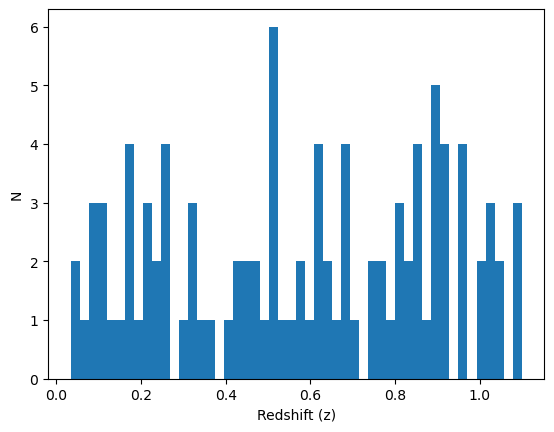

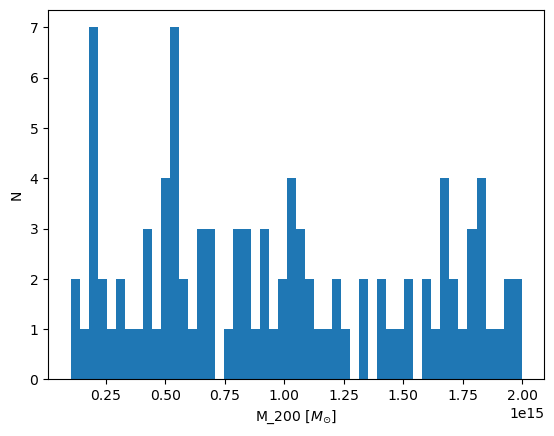

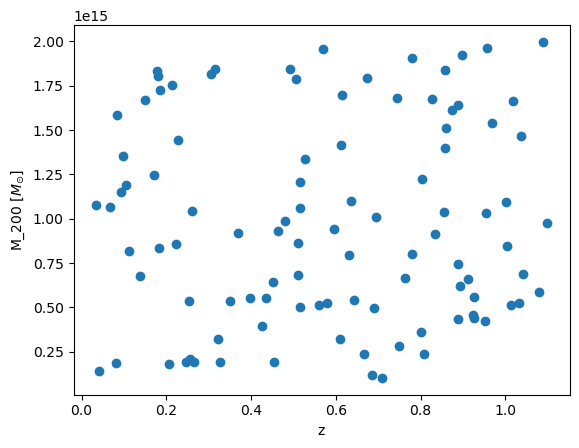

In [3]:
#Generate a new flat z, M_200 distribution and save to file: 
nsources = 100 #Number of halos to generate
zdist, mdist=simsz.dm_halo_dist.flatdist_halo(0.01,1.1,1e14,2e15,nsources) #Generate a flat z, M_200 distribution for sims

plt.hist(zdist,bins=50) #Show the z distribution 
plt.ylabel('N'),plt.xlabel('Redshift (z)')
plt.show()
plt.hist(mdist,bins=50) #Show the M_200 distribution 
plt.ylabel('N'),plt.xlabel(r'M_200 [$M_{\odot}$]')
plt.show()
plt.plot(zdist,mdist,'o') #Show the z, M_200 scatterplot
plt.xlabel('z'),plt.ylabel(r'M_200 [$M_{\odot}$]')
plt.show()

sourceid=int(time.time()) #Create an initial ctime for the halo ID list to save catalog
idlist=[sourceid+x for x in range(len(zdist))] #Create the halo ID list for catalog

#Save this array to a h5 file
data = h5py.File('massdist.h5', 'w')
data.create_dataset('Redshift', data=zdist)
data.create_dataset('Mass', data=mdist)
data.create_dataset('id', data=idlist)
data.close()

Now we are able to read our h5 file to access the distributions. We load the redshift distribution to the variable `zdist`, mass distribution to `mdist` and the list of ids corresponding to each halo to `idlist`.

In [4]:
data = h5py.File('massdist.h5', 'r')
zdist = data['Redshift'][:]
mdist = data['Mass'][:]
idlist = data['id'][:]
data.close()

## Simulating SZ submaps using these halos

The following code walks through how to use methods in `simsz` in order to generate simulated SZ submaps.

The following values are examples for the purpose of the tutorial. We create a radius array of 10000 values, from 0.01 to 10 in units of arcmin. We then convert to Mpc. Next we initialize example redshift and M_200 values. We then get R_200 and c_200 values from our M_200 value from Colossus.

In [5]:
r=np.linspace(0.01, 10, 1000) #arcmin
r=simsz.utils.arcmin_to_Mpc(r,d["pixel_size_arcmin"],d["cosmo"])
#make line for r in Mpc

In [6]:
z=0.48 #example redshift
M200=194038855760143.47 #example M_200 in solar masses

In [7]:
(M200,R200,c200)=simsz.make_sz_cluster.get_r200_and_c200(M200, z, load_vars_dict=d) #Use M200 to get R200 and concentration from Colossus

### Thermal Pressure Profile Generation

This section will walk through how to generate thermal pressure profiles using equations from __[Battaglia 2012](https://arxiv.org/pdf/1109.3711.pdf)__ Section 4 (The Thermal Pressure Profile).

`P200` represents the R_200 normalized thermal pressure profile for a cluster of galaxies. 

In [8]:
P200 = simsz.make_sz_cluster.P200_Battaglia2012(M200, z, R200_Mpc=R200, load_vars_dict=d) #P200 from Battaglia et al. 2012

Here we generate fit parameters for a restricted version of a NFW profile. The input weights are chosen to be the inverse variances of fit parameter values from the individual pressure fits for each cluster within the bin.
- `P0`: amplitude
- `xc`: core-scale
- `beta`: power law index for the asymptotic fall off of the profile.

`Pth`, generated in the next block of code, is the restricted version of the NFW profile. We scale `Pth` by $ (r/R200)^3 $, like in Battaglia 2012.

In [9]:
P0 = simsz.make_sz_cluster._P0_Battaglia2012(M200,z) #Parameter computation from Table 1 Battaglia et al. 2012
xc = simsz.make_sz_cluster._xc_Battaglia2012(M200,z)
beta = simsz.make_sz_cluster._beta_Battaglia2012(M200,z)

In [10]:
Pth = simsz.make_sz_cluster.Pth_Battaglia2012(r, M200, z, d, R200_Mpc=R200) #Output Battaglia 2012 pressure profile

In [11]:
Pth_rescaled=(Pth)*(r/R200)**3.

Here, we graph the rescaled `Pth` on a log-log plot against $(r/R200)$. 

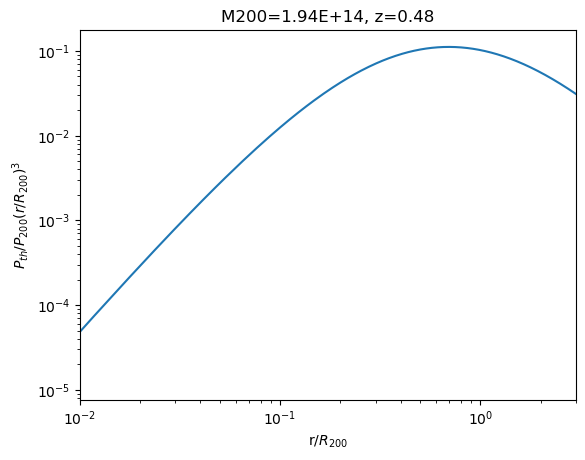

In [12]:
plt.plot(r/R200,Pth_rescaled) #Plot Battaglia 2012 pressure profile
plt.xscale('log')
plt.yscale('log')
plt.ylabel('$P_{th}/P_{200}(r/R_{200})^3$')
plt.xlabel('r/$R_{200}$')
plt.title('M200='+'{:.2E}'.format(Decimal(M200))+', z='+str(z)) #solar masses, redshift
plt.xlim(.010,3)
plt.show()

### Compton-y Profile Generation

Next, utilizing our pressure profile `Pth`, we find the Compton-y parameter (`y`) by utilizing the line of sight integral:

$$
  Y_\Delta = \frac{\sigma_T}{m_e c^2} \int_0^{R_{200}} P_e(r)4\pi r^2 \, dr$$


In [13]:
y = simsz.make_sz_cluster.Pe_to_y(simsz.make_sz_cluster.Pth_Battaglia2012, r, 
                                  M200, z, d, R200_Mpc=R200)

In [14]:
y[0] #print central y value

2.2927251793784068e-05

Next, we find the corresponding temperatures from the central y value `y[0]`. We do this by utilizing the function `f_sz` which uses the equation:  $$ \frac{\mathrm{dT}_{tsz} (\theta)}{\mathrm{T}_{CMB}} = f_{sz}  y(\theta),$$ where $y(\theta)$ is the Compton parameter at a projected angle $\theta$ from the cluster center.

In [15]:
fSZ=simsz.simtools.f_sz(150,d["cosmo"].Tcmb0) #get f_SZ for observation frequency of 30 GHz
dT=d["cosmo"].Tcmb0*y[0]*fSZ #get dT from y0 using f_SZ
dT=dT.to(u.uK) #Convert to uK
print(dT)

-59.53900476006804 uK


This is the generated 1D Compton-y profile, which plots our Compton-y profile `y` against the radius in Mpc.

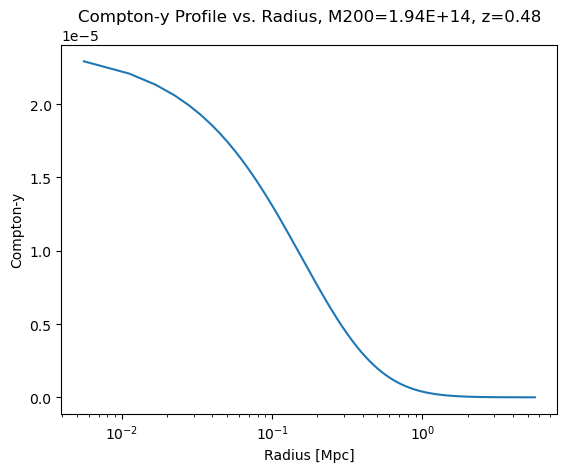

In [16]:
plt.plot(r, y)
plt.xlabel('Radius [Mpc]')
plt.ylabel('Compton-y')
plt.xscale('log')
plt.title('Compton-y Profile vs. Radius, M200='+'{:.2E}'.format(Decimal(M200))+', z='+str(z))
plt.show()

## Profile Visualization

The end goal of this section is to generate a convolved CMB map + SZ cluster with noise.

In order to create a Compton y map, we utilize the `make_y_submap` function. This 2D submap has different values than the `y` above, because of the different pixelization choices.

y_max = 1.7471741163343243e-05, y_min = 4.402218464092895e-11


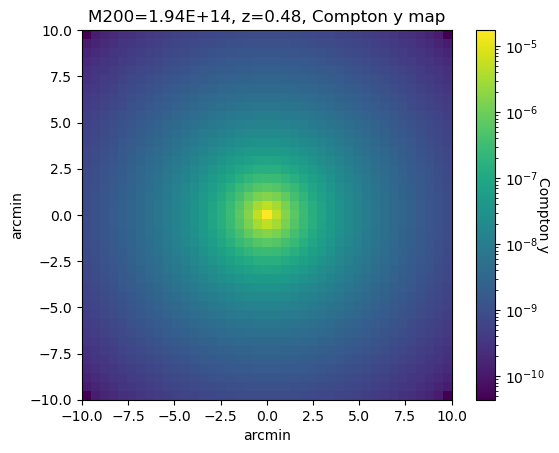

In [17]:
width = 10
y_map = simsz.make_sz_cluster.generate_y_submap(M200, z, load_vars_dict=d, R200_Mpc=R200)
simsz.visualization.plot_graphs(y_map,'M200='+'{:.2E}'.format(Decimal(M200))+', z='+str(z)+', Compton y map',
                          'arcmin', 'arcmin', 'Compton y', width=10, logNorm=True)
print(f'y_max = {y_map.max()}, y_min = {y_map.min()}')

Next, we plot the temperature map, using the $f_{sz}$ equation again: $$ \frac{\mathrm{dT}_{tsz} (\theta)}{\mathrm{T}_{CMB}} = f_{sz}  y(\theta)$$

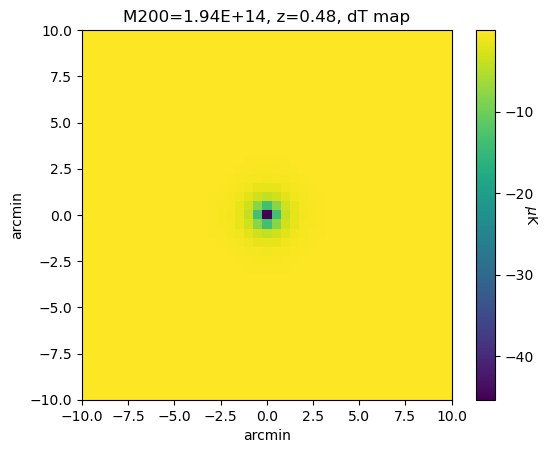

In [18]:
dT_map = (y_map * d["cosmo"].Tcmb0 * fSZ).to(u.uK).value
simsz.visualization.plot_graphs(dT_map, 'M200='+'{:.2E}'.format(Decimal(M200))+', z='+str(z)+', dT map',
                                'arcmin', 'arcmin', '$\mu$K', width=10)

### CMB submap generation

This is an example of what a generated CMB map will look like. We use the function `get_cls` in the `simtools` file to generate a power spectrum, which we then use to create the CMB map using `make_cmb_map`. This is just an example CMB map; it doesn't carry forward to the cells below. 

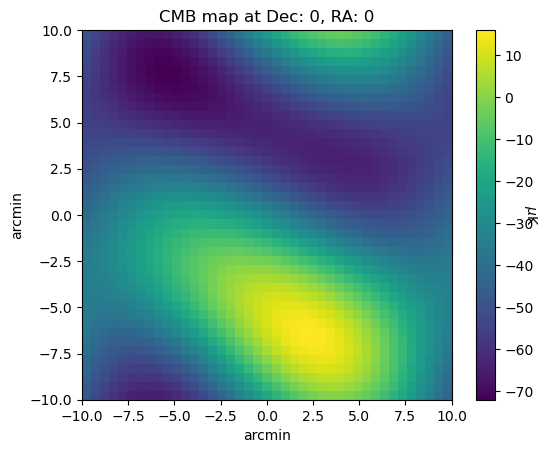

In [63]:
ps = simsz.simtools.get_cls(ns=d["ns"], cosmo=d["cosmo"])
cmb_map = simsz.simtools.make_cmb_map(shape=y_map.shape, pix_size_arcmin=d["pixel_size_arcmin"], ps=ps)*u.uK
simsz.visualization.plot_graphs(cmb_map.value,'CMB map at Dec: 0, RA: 0',
                                'arcmin','arcmin','$\mu$K', width=10)

### Creating a signal (SZ + CMB) map

This is an example of what a generated signal map will look like. 

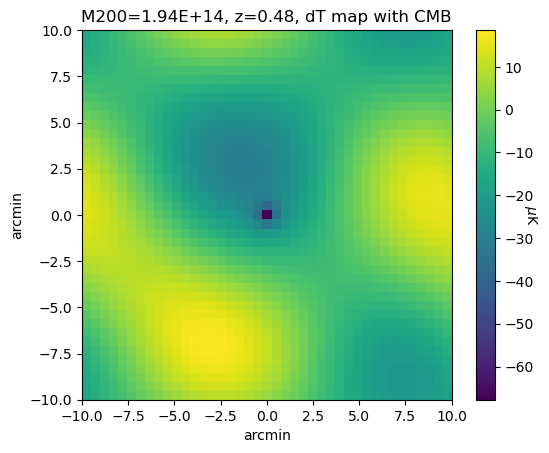

In [20]:
signal_map = dT_map + cmb_map.value 
simsz.visualization.plot_graphs(signal_map,'M200='+'{:.2E}'.format(Decimal(M200))+', z='+str(z)+', dT map with CMB',
                                'arcmin','arcmin','$\mu$K',width=10)

### Beam Convolution

This what an example CMB map post beam-convolution will look like. Here we use the method `add_cmb_map_and_convolve` in `simtools`, which creates a CMB map, adds our cluster, convolves with a beam, and then eliminates edge effects.

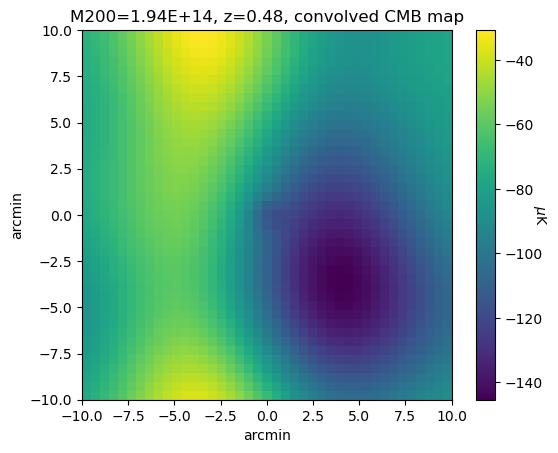

In [21]:
conv_map, _ = simsz.simtools.add_cmb_map_and_convolve(dT_map, ps, d["pixel_size_arcmin"], d["beam_size_arcmin"])
simsz.visualization.plot_graphs(conv_map,'M200='+'{:.2E}'.format(Decimal(M200))+', z='+str(z)+', convolved CMB map',
                                'arcmin','arcmin','$\mu$K',width = 10)

### Adding Noise

Next, we add a white noise map to the convolved CMB map using the `generate_noise_map` function in `noise`.

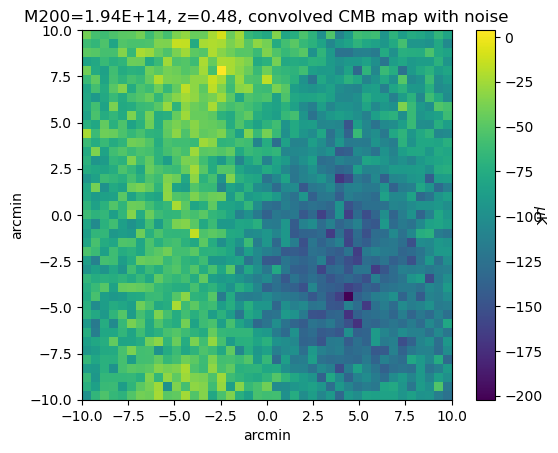

In [39]:
noise_map=simsz.noise.generate_noise_map(d["image_size_pixels"], d["noise_level"], d["pixel_size_arcmin"])
total_map=conv_map + noise_map
simsz.visualization.plot_graphs(total_map,'M200='+'{:.2E}'.format(Decimal(M200))+', z='+str(z)+', convolved CMB map with noise',
                                'arcmin','arcmin','$\mu$K', width = 10, extend=True)

### Aperture Photometry

We can use the function `get_tSZ_signal_aperture_photometry` from `filters` to associate an tSZ signal to our cluster. This is a demonstration of how to use the aperture photometry tool.

Average in inner radius: -113.11628186636442
Average in outer radius: -108.293428179651
tSZ signal: -4.822853686713415


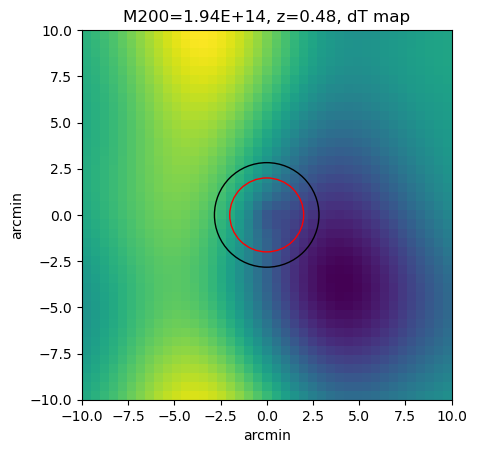

In [40]:
ap_arcmin=2.0 #arcminutes
disk, ring, signal = simsz.filters.get_tSZ_signal_aperture_photometry(conv_map, ap_arcmin)
print('Average in inner radius: '+str(disk))
print('Average in outer radius: '+str(ring))
print('tSZ signal: '+str(signal))
center = np.array(conv_map.shape) / 2
center = center - center[0]
fig, ax = plt.subplots()
ax.imshow(conv_map, extent=[-width,width,-width,width])
disk_circle = plt.Circle(center, ap_arcmin, color='red', fill=False, linewidth=1)
annulus_circle = plt.Circle(center, ap_arcmin * np.sqrt(2), color='black', fill=False, linewidth=1)
ax.add_patch(disk_circle)
ax.add_patch(annulus_circle)
plt.ylabel('arcmin')
plt.xlabel('arcmin')
plt.title('M200='+'{:.2E}'.format(Decimal(M200))+', z='+str(z)+', dT map')
plt.show()


## Creating Sims without step by step functions

For more on overall sim generating functions see `demo_simulation.ipynb`.

This code simulates 100 clusters using the previously defined `mdist` and `zdist`. You can change the number of simulated clusters by varying `nsources`, defined above.

In [65]:
#This simulates submaps for a distribution, and saves the data to a h5 file, and params to a yaml file
clusters = simsz.make_sz_cluster.simulate_T_submaps(mdist, zdist)

If you want to create simulated clusters without previously defining a mass and redshift distribution, you can use the `simulate_clusters` class in `make_sz_cluster.py`. You can specify the following characteristics of the simulated clusters:
- M200
- redshift
- number of halos
- halo parameters
- R200

We will create a galaxy cluster of 100 halos as an example:

In [67]:
cl = simsz.make_sz_cluster.simulate_clusters(num_halos=100)

making 100 clusters uniformly sampled from 0.1<z<1.1, 1e13<M200<1e14


The `simulate_clusters` class has multiple methods to get different characteristics of the simulated clusters. 
- Compton-y map: `get_y_map`
- dT map: `get_dT_map`
- Temperature map: `get_T_map`

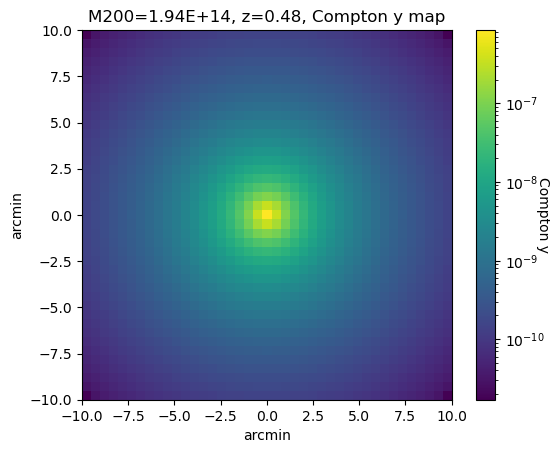

In [68]:
simulated_map = cl.get_y_maps()[0]
simsz.visualization.plot_graphs(simulated_map,'M200='+'{:.2E}'.format(Decimal(M200))+', z='+str(z)+', Compton y map',
                                'arcmin','arcmin','Compton y',width=10,logNorm=True, extend=True)

## Storing Sims

This is an example block of code for storing simulated submaps. It saves the simulation data into the h5 file `sz_sim_data.h5`, with `sim_id` label as 1.

In [52]:
sim_id = 1
# Data to be stored:
data = {
'temperature_submap': dT_map,
'noise_submap' : np.zeros((10,10)),
'cmb_submap' : cmb_map,
'y_central' : y_map[width][width],
'M200': M200,
'redshift_z': z,
'concentration': c200,
'ID': sim_id,
}
with h5py.File('sz_sim_data.h5', 'a') as f:
    simsz.utils.save_sim_to_h5(f, f"sim_{sim_id}", data, overwrite=True)

Here is how to visualize the beam convolved CMB map of a simulated cluster:

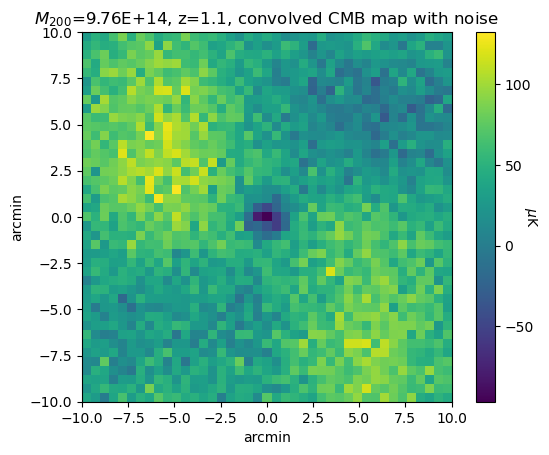

In [94]:
simulated_map = clusters[80]['final_map']
simsz.visualization.plot_graphs(simulated_map,'$M_{200}$='+ '{:.2E}'.format(Decimal(clusters[80]["M200"])) + ', z=' + '{:.2}'.format(Decimal((clusters[80]["redshift_z"]))) + ', convolved CMB map with noise','arcmin','arcmin','$\mu$K', width=10)

The class `simulate_submaps` also has a `save_map` function that can save individual maps or this class instance has a `save_map` method that can save individual maps as specified, or all clusters into a single nested file with `nest_h5 = True`, or all clusters individually.

In [69]:
# cl.save_map()